# Extract image pathces of target from Database query

This notebook extracts an image patch around the target area. It is based on the query images notebook and uses that as a base to find the images where the target is in frame. It then uses Superpoint and Lightglue
for feature detection and matching in order warp the images and extract the image patches with higher accuracy.

For this notebook to work, you will require a working ArangoDB. See http://localhost:8888/lab/tree/1_import_bagfiles.ipynb for how to set that up.

It is divided into multiple parts. The first part will require you to specify the targets location. The program will then query the database for all images of that location. The second part will require you to select your target from one of the images. After that the program will match and warp the remaining images to that image and save the image patches in the correct folder for the CNN training.

## Set Up
Import the requiered libraries and scripts

In [1]:
%matplotlib widget
import numpy as np
import quaternion
import cv2
import os
import random
import shutil

import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.colors as mcolors
import time

from matplotlib.widgets import Button
from IPython.display import display, clear_output
from jupyter_ui_poll import ui_events

import torch
from lightglue import SuperPoint
from lightglue.utils import load_image

import scripts.query_image as query_image
import scripts.save_patch as save_patch
import scripts.divide_data as divide_data
import scripts.points_and_polygons as points_and_polygons

start_time = time.time()


# Parameters
ros_topic_pose = "/gnc/ekf".replace("/", "_")[1:]
ros_topic_image = "/hw/cam_sci/info".replace("/", "_")[1:]

Specify the targets location and size

Also specify your base image. This should be an image containing your target(s).

In [2]:
# Target Pose
target_position = np.array([-0.84, 0.6, -0.81])
target_attitude = quaternion.from_euler_angles(0, 0, np.radians(180))  # order is roll, pitch, yaw

# Query Contraints
max_distance = 1.0
min_distance = 0.2
max_angle = 30

# Target size, the target is pointed to in the x-axis
target_size_y = 0.05
target_size_z = 0.07

# Base_image, pick an image to have as a base image
base_image_path = 'PATH_TO_BASE_IMAGE'

Define the image data folder and where you would like the program to save the extracted image patches. The program will group the images by bagfile in the specified directory. They will have a the same name as the source image with patch added to the front:

In [3]:
# Define the paths for the directory with the image data and where the patches should be saved
image_path = 'PATH_TO_SCI_CAM_IMAGES' # Enter the path to the sci cam images, usually in the "isaac_sci_cam_image_delayed" folder
save_path = 'PATH_TO_WHERE_TO_SVAE_THE_IMAGES'

bag_directory_path = 'data/bags/' # Specify the path to your bagfiles

# Define the paths for the training and testing directories
train_test_dir = 'PATH_TO_WHERE_TO_SAVE_DATASET'


# Print image and directory information?
print_info = False

## Target selection with UI

This section plots an image and allows the user to select one or more targets by clicking on the corners of the target(s). Once done the user should press continue. To redo the selection, press reset.

In [4]:
# Define function to handle mouse click event
def onclick(event):
    global color
    if event.inaxes == ax:
        x = int(event.xdata)
        y = int(event.ydata)
        clicked_points.append((x, y))
        HSV_color = (color, 1.0, 1.0)  # Color in HSV, (hue, saturation, value) all between 0 and 1
        RGB_color = mcolors.hsv_to_rgb(HSV_color)
        ax.plot(x, y, 'o', color = RGB_color, markersize = 2)  # Plot a dot at the clicked position
        fig.canvas.draw()

# Define function to handle button click event
def on_continue_button_clicked(b):
    time.sleep(0.1)
    plt.close()
    global waiting
    waiting = False

def on_reset_button_clicked(b):
    global clicked_points
    clicked_points = []
    ax.clear()
    ax.imshow(image)
    input_widget.value = ''
    fig.canvas.draw()

Label(value='Please select the four corners of your target by clicking on them in any order.')

Button(description='Continue', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

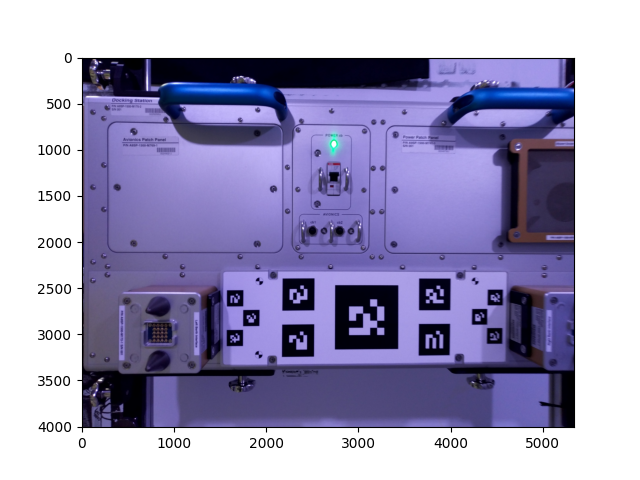

In [5]:
waiting = True

# Load your image
image = plt.imread(base_image_path)

color = 0

point_list = []

# Initialize list to store clicked coordinates
clicked_points = []

# Create a figure and axis
fig, ax = plt.subplots()
ax.imshow(image)

# Connect the onclick function to the mouse click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Create a widgets
prompt_label = widgets.Label(value = 'Please select the four corners of your target by clicking on them in any order.')
#continue_button = widgets.Button(description = 'Continue')
reset_button = widgets.Button(description = 'Reset')
continue_button = widgets.Button(description = 'Continue')


display(prompt_label)
display(continue_button)
display(reset_button)
plt.show()


# Attach button click event handlers
reset_button.on_click(on_reset_button_clicked)
continue_button.on_click(on_continue_button_clicked)
with ui_events() as poll:
    while waiting == True:
        if len(clicked_points) == 4:
            color = (color + 0.1) % 1
            point_list.append(clicked_points)
            clicked_points = []
        
            
        #waiting for user input
        poll(10) # poll queued UI events including button
        pass

## Extract the image patch around the target area

Using the selection from the previous section the program extracts the patch around the target(s). 

It uses superpoint to extract the features from the base image, it then uses lightglue to feature match them and openCV to calculate a homography and warp the image.

The scripts are located under the scripts folder in the analyst directory.

In [6]:
corners = points_and_polygons.identify_corners(point_list)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if Nvidia CUDA is supported by the gpu otherwise set device to cpu
base_image = load_image(base_image_path)
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # Load Superpoint as the extractor
feats_base_image = extractor.extract(base_image.to(device))

bags = os.listdir(bag_directory_path) # Load a list of all the bags in the bag directory
total_images_saved = 0 # Initialize the counter for the amount of total images saved
for bag in bags: # Go though the bags one by one
    bag_path = os.path.join(bag_directory_path, bag) # The path to that specific bag file

    if os.path.isfile(bag_path) and bag_path.endswith('.bag'): # Confirm that it is a bag file
        print('Extracting from bag ' + bag) # Inform user of extraction process
        
        # Query the data base for images with the target in the bagfile
        result = query_image.query_image_of_bag(target_position, target_attitude, ros_topic_pose, ros_topic_image, max_distance, min_distance, max_angle, target_size_y, target_size_z, bag) 
        if result is not None: # Check if the query found any images or if the result is empty
            total_images_saved = save_patch.save_images(result, image_path, base_image_path, corners, save_path, bag, total_images_saved, feats_base_image, print_info) # If the query was sucessful, save the images
            
        else:
            print('No images found\n') # Otherwise inform the user that no images was found

# Print information about amount of pictures saved and that the process is complete
print('Saved a total of ' + str(total_images_saved) + ' images')
print('Image patch extraction complete')

Extracting from bag 20240321_2238_survey_test_profile_0.fix_all.bag
Connected to isaac database
From database got 0 matches
From first filtering got 0 matches
Query successful, got 0 matches
No images found

Extracting from bag 20240321_2232_survey_test_0.fix_all.bag
Connected to isaac database
From database got 22 matches
From first filtering got 0 matches
Query successful, got 0 matches
No images found

Extracting from bag 20240321_2254_survey_bsharp7_0.fix_all.bag
Connected to isaac database
From database got 96 matches
From first filtering got 43 matches
Query successful, got 43 matches
Saved 86 images
Done extracting and saving image patches from bag

Extracting from bag 20240321_2250_survey_bsharp5_0.fix_all.bag
Connected to isaac database
From database got 32 matches
From first filtering got 18 matches
Query successful, got 18 matches
Saved 34 images
Done extracting and saving image patches from bag

Extracting from bag 20240321_2245_survey_bsharp3_0.fix_all.bag
Connected to isa

## Divide image patches into training and testing data
This section goes through the folders with the extracted patches and divides them into train and test data for use in the building of the CNN model.

We need to define which case each bag corresponds to. This currently has to be done by hand.

In [1]:
# Define a dictionary mapping bagfiles names to class labels
bag_case = {
    'BAGFILE_ONE': 'on',
    'BAGFILE_TWO': 'on',
    'BAGFILE_THREE': 'off',
    'BAGFILE_FOUR': 'off',
    'BAGFILE_FIVE': 'on',
    'BAGFILE_SIX': 'on',
    'BAGFILE_SEVEN': 'off',
    'BAGFILE_EIGHT': 'off'
}

In [7]:
amount_of_training_data = 0.8 # 80% is going to be training data
amount_of_targets = len(point_list)

# Makes the directories for the training data. Note: This deletes all old data in the specified directories
directories_made = divide_data.make_directories(train_test_dir, amount_of_targets)


# Divides the training data into training and testing for the model.
divide_data.divide_data(bag_case, save_path, directories_made, amount_of_training_data)
        

Data copying and organization completed.

Amount of total data is: 410
Amount of training data is: 159
Amount of test data is: 46


In [8]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Notebook executed in: {execution_time:.1f} seconds")

Notebook executed in: 27.6 seconds
